# EDA
Zbiór danych - https://archive.ics.uci.edu/ml/datasets/A+study+of++Asian+Religious+and+Biblical+Texts#

In [72]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pyLDAvis.sklearn

from sklearn.decomposition import LatentDirichletAllocation, NMF
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.cluster import KMeans

from scipy.cluster import hierarchy

from wordcloud import WordCloud
from textwrap import wrap
from textblob import TextBlob
from textstat import flesch_reading_ease, difficult_words, automated_readability_index, text_standard

import nltk
from nltk.corpus import stopwords

import re
import warnings
warnings.filterwarnings("ignore")

## Opis zbioru danych
Zbiór składa się z tekstów z 8 ksiąg religijnych. Księgi te można podzielić na 4 kategorie.
- Hinduism (India):  Yogasutras, Upanishads
- Buddhism (Tibet):  Four Noble Truth of Buddhism
- Taoism (China):  Tao Te Ching
- Christianity (Central Asia/America):  Book of Proverb, Book of Ecclesiastes, Book of Ec-clesiasticus, Book of Wisdom

Skorzystamy z surowego tekstu.

In [15]:
file = open('Complete_data .txt', 'r')
file_content = file.read()
file.close()


content_list = re.split('\d+\.\d+', file_content)

In [24]:
indices = []
corpus = []
for idx in range(len(content_list)):
    stripped = content_list[idx].strip()
    if stripped != '':
        corpus.append(content_list[idx])

In [25]:
len(corpus)

591

## Bag of Words

Rozdzielamy każdy z tekstów na słowa oraz zliczamy liczbę wystąpień danego słowa dla każdego z tekstów przy pomocy narzędzia CountVectorizer.

Wybieramy słowa które znajdują się w mniej niż 90% tekstów oraz wystapują w co najmniej dwóch tekstach.
Poza tym usuwamy stopwords, a także wybieramy tylko wyrazy składające się z liter.

In [26]:
c_vectorizer = CountVectorizer(max_df=0.9, min_df=2, stop_words='english', token_pattern=r"\b[^\d\W]+\b")
cv = c_vectorizer.fit_transform(corpus)

cv_features = c_vectorizer.get_feature_names()
df_word_count = pd.DataFrame(cv.toarray(), columns=list(cv_features))

print(f'Liczba różnych słów: {len(cv_features)}')

Liczba różnych słów: 4236


## Najpopularniejsze słowa

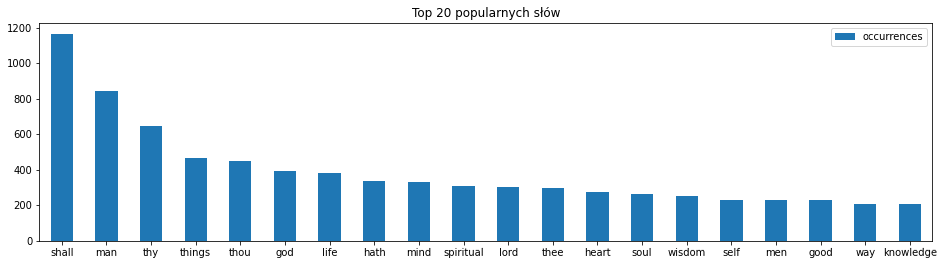

In [29]:
all_counted = df_word_count.sum(axis = 0, skipna = True)
all_counted = pd.DataFrame(all_counted, columns = ['occurrences'])
all_counted = all_counted.sort_values(by = 'occurrences', ascending = False)

all_counted.iloc[0:20,].plot(kind = "bar", figsize = (16, 4), rot = 0.2, title = "Top 20 popularnych słów")
plt.show()

In [31]:
cloud_text = all_counted.to_dict()
cloud_text = cloud_text['occurrences']

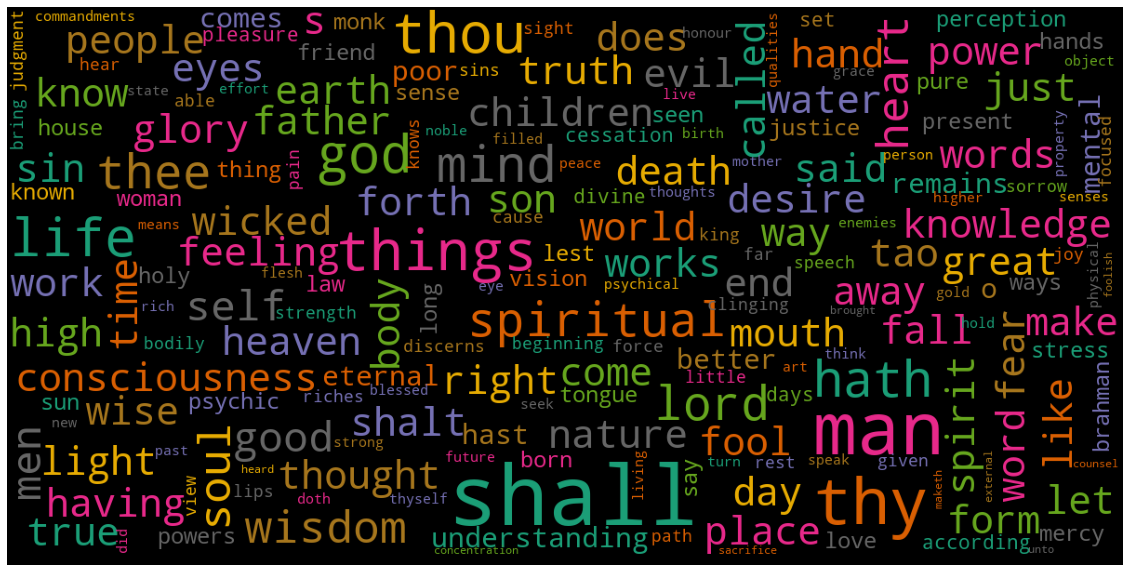

In [32]:
wordcloud = WordCloud(max_font_size=30,
                        scale=3,
                        random_state=1,
                        colormap='Dark2').generate_from_frequencies(cloud_text)     

fig = plt.figure(1, figsize=(20, 12))
plt.axis('off')    
plt.imshow(wordcloud)
plt.show()


## Długości wyrazów
Do tego celu wykorzystamy wszystkie wyrazy poza stopwords.

In [101]:
# ramka do przechowywania cech plików
df_features = pd.DataFrame()

In [37]:
c_vectorizer2 = CountVectorizer(stop_words='english', token_pattern=r"\b[^\d\W]+\b")
cv2 = c_vectorizer2.fit_transform(corpus)

cv_features2 = c_vectorizer2.get_feature_names()
df_all = pd.DataFrame(cv2.toarray(), columns=list(cv_features2))

print(f'Liczba różnych słów: {len(cv_features2)}')

Liczba różnych słów: 7905


In [38]:
all_counted = df_all.sum(axis = 0, skipna = True)
all_counted = pd.DataFrame(all_counted, columns = ['occurrences'])
all_counted = all_counted.sort_values(by = 'occurrences', ascending = False)

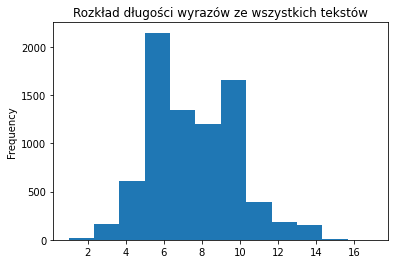

In [118]:
all_counted['nchars'] = all_counted.index.str.split('')
all_counted['nchars'] = all_counted['nchars'].apply(lambda x: len(x)-2)

all_counted['nchars'].plot(kind = 'hist', title = 'Rozkład długości wyrazów ze wszystkich tekstów', bins = 12
                           , xlabel = "Liczba liter", ylabel = 'Liczba słów o danej długości')
plt.show()

## Zliczanie liczby słów dla tekstów
Na podstawie danych zsumowanych wierszowo - np. `1. tekst`: `liczba słów kluczowych`.

### Zliczenie unikalnych słów

In [43]:
arr = np.array(df_all)
arr = arr >=1
arr = arr.astype(int)

df_ex = pd.DataFrame(arr, columns = df_all.columns)

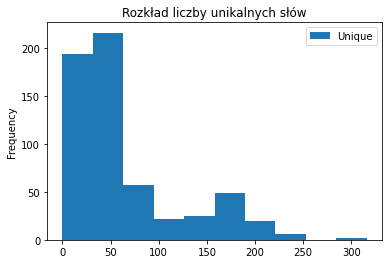

In [54]:
row_ex = df_ex.sum(axis = 1)
row_ex = pd.DataFrame(row_ex, columns = ['Unique'])

row_ex.plot(kind = 'hist', rot = 0.2, title = 'Rozkład liczby unikalnych słów')
plt.show()

In [107]:
df_features = row_ex

In [59]:
print(f'Średnia liczba unikalnych słów w tekście wynosi: {round(np.mean(row_ex)[0], 0)}')

Średnia liczba unikalnych słów w tekście wynosi: 64.0


### Zliczenie wszystkich słów poza stopwords

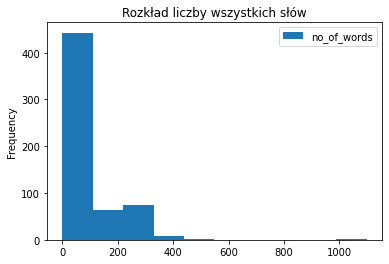

In [109]:
row_counted = df_all.sum(axis = 1)
row_counted = pd.DataFrame(row_counted, columns = ['no_of_words'])

row_counted.plot(kind = 'hist', rot = 0.2, title = 'Rozkład liczby wszystkich słów')
plt.show()

In [110]:
df_features['no_of_words'] = row_counted

## Analiza bloku tekstu

In [65]:
def polarity(text):
    return TextBlob(text).sentiment.polarity

def subjectivity(text):
    return TextBlob(text).sentiment.subjectivity

corpus_df = pd.DataFrame(corpus, columns = ['text'])

corpus_df['polarity'] = corpus_df['text'].apply(lambda x : polarity(x))
corpus_df['subjectivity'] = corpus_df['text'].apply(lambda x : subjectivity(x))
corpus_df

,text,polarity,subjectivity
0,"\n§ 1.The Buddha: ""What do you think, Rahula: ...",-0.059836,0.395902
1,\n§ 2.Once the Blessed One was staying at Kosa...,0.117647,0.477941
2,"\n§ 3.""'Stress should be known. The cause by w...",0.180979,0.547078
3,"\n§ 4.""Vision arose, clear knowing arose, disc...",0.343080,0.664732
4,"\n§ 5.Sariputta: ""There are these three forms ...",0.000000,0.000000
...,...,...,...
586,\ncondemning both the makers and the worshippe...,0.010802,0.569444
587,"\nworthily punished, and were destroyed by a m...",0.133667,0.569179
588,"\n 17:1. For thy judgments, O Lord, are great,...",-0.076437,0.650194
589,"\nintercession, in the sedition on occasion of...",0.042108,0.597840


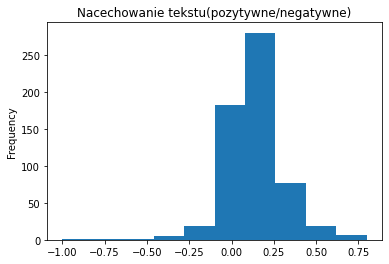

In [66]:
corpus_df['polarity'].plot(kind = 'hist', title = 'Nacechowanie tekstu(pozytywne/negatywne)')
plt.show()

Wartości ujemne oznaczają negatywne zabarwienie tesktu, wartości dodatnie - teskt o pozytywnym przekazie.

Możemy zaobserwować, że większość tekstów jest nacechowana pozytywnie.

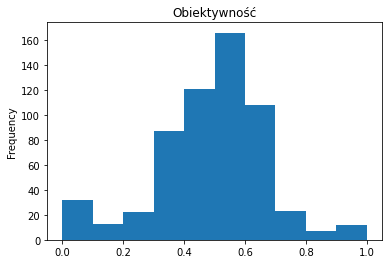

In [69]:
corpus_df['subjectivity'].plot(kind = 'hist', title = 'Obiektywność')
plt.show()

0 - tekst obiektywny, 1 - tekst subiektywny

In [113]:
df_features['polarity'] = corpus_df['polarity']
df_features['subjectivity'] = corpus_df['subjectivity']

## Analiza złożoności tekstu

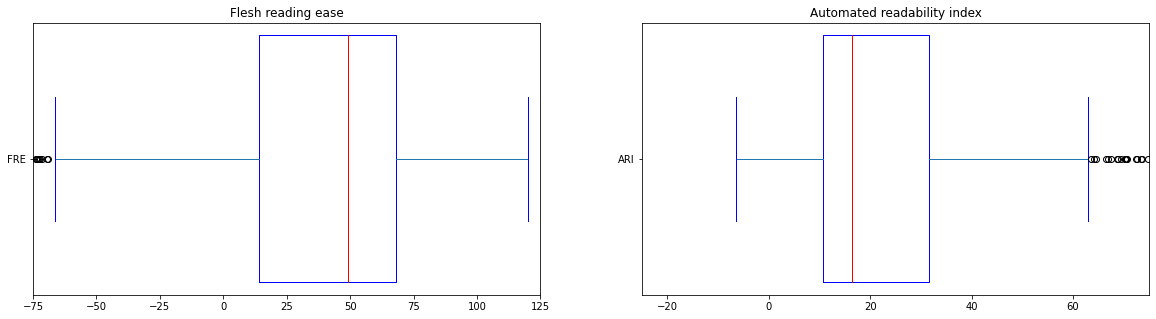

In [114]:
corpus_df['FRE'] = corpus_df['text'].apply(lambda x : flesch_reading_ease(x))
corpus_df['ARI'] = corpus_df['text'].apply(lambda x : automated_readability_index(x))

df_features['FRE'] = corpus_df['FRE']
df_features['ARI'] = corpus_df['ARI']

fig, ax = plt.subplots(1,2, figsize=(20, 5))
corpus_df['FRE'].plot(kind = 'box', vert = False, xlim = [-75, 125],
                                 title = 'Flesh reading ease', widths = 5, ylabel = '', ax = ax[0],
                                 color = {'boxes':'blue','medians':'red', 'caps':'blue'})

corpus_df['ARI'].plot(kind = 'box', vert = False, xlim = [-25, 75],
                                     title = 'Automated readability index', widths = 5, ylabel = '',
                                      color = {'boxes':'blue','medians':'red', 'caps':'blue'}, ax = ax[1])
plt.show()

In [75]:
print('Mediana wartości `Flesh reading ease`:', corpus_df['FRE'].median(axis = 0))
print('Mediana wartości `Automated readibility index`:', corpus_df['ARI'].median(axis = 0))

Mediana wartości `Flesh reading ease`: 49.15
Mediana wartości `Automated readibility index`: 16.5


### FRE
$FRE = 206.835 - 1.015(\frac{words}{sentences}) - 84.6 (\frac{syllables}{words})$
![text_level.png](text_level.png)
### ARI
$ARI = 4.71(\frac{characters}{words}) + 0.5 (\frac{words}{sentences}) - 21.43$

![ARI.png](ARI.png)

- uśredniony poziom skomplikowania tekstu jest określany jako `nieznacznie trudny`
- szacowany poziom edukacji potrzebny do zrozumienia tekstu to tytuł profesora.

## LDA
Przy pomocy LDA postaramy się wykryć tematy przewodnie w tekstach. Skorzystamy tylko z wyrazów, które występują co najmniej dwukrotnie.

In [78]:
lda_model = LatentDirichletAllocation(n_components=8, 
                                      learning_method='batch', 
                                      max_iter=300, 
                                      random_state=0).fit(cv)

In [79]:
no_top_words = 10
def display_topics(model, feature_names, no_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print("Topic %d:" % (topic_idx))
        print(" ".join([feature_names[i]
                            for i in topic.argsort()[:-no_top_words - 1:-1]]))

In [80]:
display_topics(lda_model, c_vectorizer.get_feature_names(), no_top_words)

Topic 0:
body remains monk mind focused discerns feeling qualities reference away
Topic 1:
shall thy man thou hath god things thee lord wisdom
Topic 2:
stress cessation called clinging consciousness fabrications form feeling aggregate contact
Topic 3:
god soul darkness fear life shall love worship seen mind
Topic 4:
right know having mind perception self view knowledge pleasure consciousness
Topic 5:
self senses like atman mind tao men intellect knowledge world
Topic 6:
spiritual man life mind self consciousness power soul things powers
Topic 7:
knowledge things property death does water sees way brahman said


### Proponowane przez nas tematy

0. Monk - Body and Mind
1. Christianity - God
2. Feeling and Consciousness
3. Fear and Love
4. Knowledge and Mind Perception
5. Taoism - Intellect
6. Spiritual Man Life and Soul
7. Property and Knowledge

In [81]:
pyLDAvis.enable_notebook()
panel = pyLDAvis.sklearn.prepare(lda_model, cv, c_vectorizer, mds='tsne')
panel

PreparedData(topic_coordinates=                x           y  topics  cluster       Freq
topic                                                    
1     -108.958252 -208.941483       1        1  49.052845
6      186.487061  -98.103249       2        1  17.613333
4       19.245832  160.858780       3        1   8.738128
7      170.658829   75.445076       4        1   7.311992
0       -1.386411  -35.043739       5        1   6.135045
5     -145.800095  106.944611       6        1   4.653311
2       64.834541 -221.825272       7        1   4.217971
3     -196.906036  -58.990913       8        1   2.277375, topic_info=             Term         Freq        Total Category  logprob  loglift
6202        shall  1120.000000  1120.000000  Default  30.0000  30.0000
6533    spiritual   278.000000   278.000000  Default  29.0000  29.0000
7059          thy   620.000000   620.000000  Default  28.0000  28.0000
3038          god   366.000000   366.000000  Default  27.0000  27.0000
6475         soul   241.000000   241.000000  Default  26.0000  26.0000
...           ...          ...          ...      ...      ...      ...
3477  immortality     2.578380    22.045313   Topic8  -6.1853   1.6362
7826        world     3.362927   135.716304   Topic8  -5.9197   0.0844
7818         work     3.036060    79.602664   Topic8  -6.0219   0.5157
3100        great     3.315145   182.296876   Topic8  -5.9340  -0.2250
7006       things     3.399798   428.516569   Topic8  -5.9088  -1.0545

[557 rows x 6 columns], token_table=      Topic      Freq        Term
term                             
25        3  0.145888       abode
25        4  0.291776       abode
25        6  0.583553       abode
43        2  0.900603  absorption
72        6  0.894624  accordance
...     ...       ...         ...
7882      3  0.288605        yama
7882      4  0.288605        yama
7882      6  0.384806        yama
7882      8  0.048101        yama
7898      2  0.919994        yoga

[1214 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 7, 5, 8, 1, 6, 3, 4])

## Tf-idf
Mierzy wagę słowa dla danego tekstu, porównując liczbę wystąpień danego słowa w dokumencie z liczbą dokumentów w których to słowo występuje.
- $TF_{i, j}$ - liczba wystąpień i-tego słowa w j-tym tekście,
- $DF_i$ - liczba dokumentów zawierająca i-te słowo,
- $N$ - liczba dokumentów.

Dla słowa $i$ w dokumencie $j$:
$$w_{i, j} = TF_{i, j} * log(\frac{N}{DF_i})$$

In [82]:
tfidf_vectorizer = TfidfVectorizer(max_df=0.9, min_df=2, use_idf=True, stop_words='english', token_pattern=r"\b[^\d\W]+\b")

tfidf = tfidf_vectorizer.fit_transform(corpus)
tfidf_feature_names = tfidf_vectorizer.get_feature_names()

df_tfidf = pd.DataFrame(tfidf.toarray(), columns=list(tfidf_feature_names))
df_tfidf

,aaron,abandoned,abandoning,abasement,abateth,abhor,abhorreth,abide,abides,abiding,...,yes,yesterday,yield,yieldeth,yields,yoga,yoke,young,youth,zeal
0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.096314,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
586,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
587,0.0,0.000000,0.0,0.0,0.053168,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
588,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
589,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Ponownie definiujemy tematy
Tym razem powinny być one lepiej dopasowane.

In [83]:
nmf = NMF(n_components=8, random_state=0, alpha=.1, init='nndsvd').fit(tfidf)
display_topics(nmf, tfidf_feature_names, no_top_words)

Topic 0:
shall man hath wicked god lord just wise wisdom fool
Topic 1:
spiritual man consciousness powers power life psychical psychic divine soul
Topic 2:
thy thou thee shalt let hast hath shall god lest
Topic 3:
mind senses intellect atman objects higher control know driver eye
Topic 4:
tao does things heaven great men know sage people state
Topic 5:
brahman said devas vayu nachiketas know replied able indra worship
Topic 6:
self beings eternal sees seated life atman sorrow body soul
Topic 7:
right stress cessation feeling consciousness fabrications noble monk perception concentration


0. Lord's Wisdom
1. Spirituality and Consciousness
2. Christianity - God
3. Mind and Intellect
4. Tao does great things
5. Brahman and Worship
6. Hinduism - Eternal Beings 
7. Noble Monk Perception

Przypiszemy uzyskane tematy do wszystkich tekstów.

In [115]:
nmf_topic_values = nmf.transform(tfidf)
df_features['nmf_topics'] = nmf_topic_values.argmax(axis=1)
lda_topic_values = lda_model.transform(cv)
df_features['lda_topics'] = lda_topic_values.argmax(axis=1)

nmf_remap = {0: 'Lord\'s Wisdom', 
           1: 'Spirituality and Consciousness', 
           2: 'Christianity - God', 
           3: 'Mind and Intellect', 
           4: 'Tao does great things', 
           5: 'Brahman and Worship', 
           6: 'Hinduism - Eternal Beings', 
           7: 'Noble Monk Perception'}

df_features['nmf_topics'] = df_features['nmf_topics'].map(nmf_remap)

lda_remap = {0: 'Monk - Body and Mind',
            1: 'Christianity - God',
            2: 'Feeling and Consciousness',
            3: 'Fear and Love',
            4: 'Knowledge and Mind Perception',
            5: 'Taoism - Intellect',
            6: 'Spiritual Man Life and Soul',
            7: 'Property and Knowledge'}

df_features['lda_topics'] = df_features['lda_topics'].map(lda_remap)

Sprawdzimy jak częsty jest każdy z tematów.

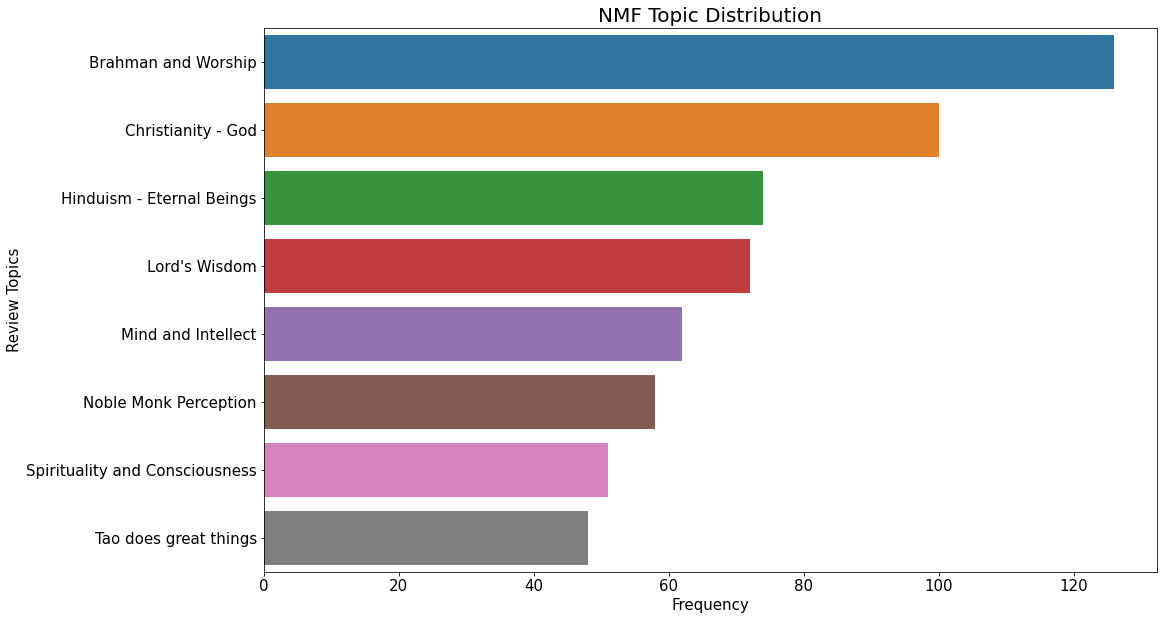

In [99]:
nmf_x = df_features['nmf_topics'].value_counts()
nmf_y = nmf_x.sort_index()

plt.figure(figsize=(16,10))
sns.barplot(nmf_x, nmf_y.index)

plt.title("NMF Topic Distribution", fontsize=20)
plt.ylabel('Review Topics', fontsize=15)
plt.yticks(fontsize=15)
plt.xlabel('Frequency', fontsize=15)
plt.xticks(fontsize=15)
plt.show()

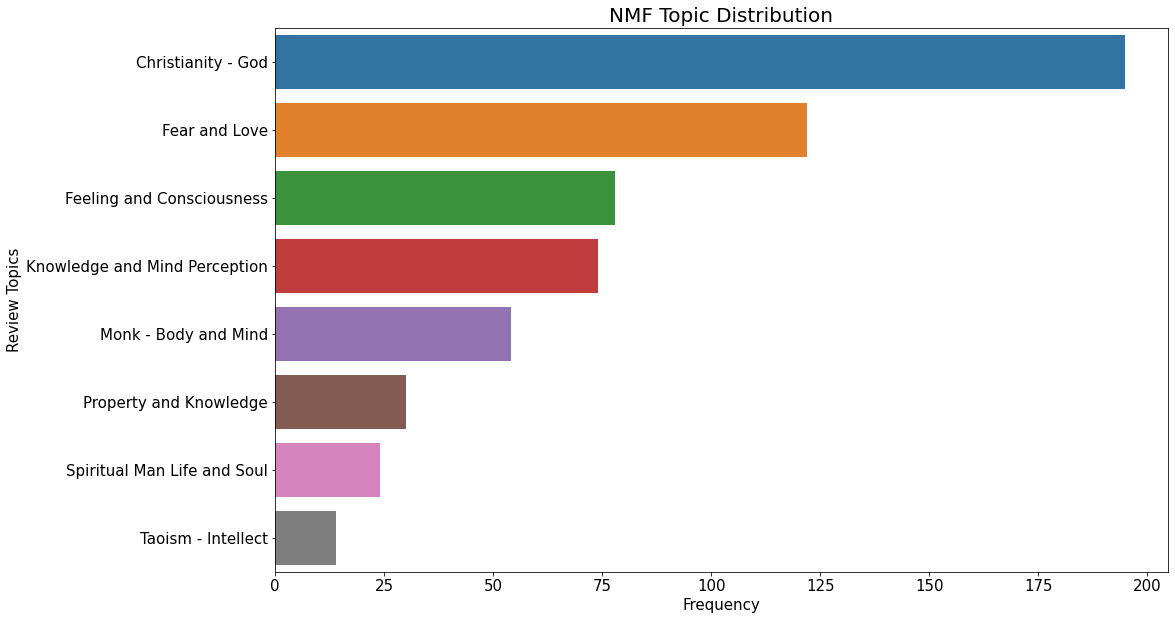

In [100]:
lda_x = df_features['lda_topics'].value_counts()
lda_y = lda_x.sort_index()

plt.figure(figsize=(16,10))
sns.barplot(lda_x, lda_y.index)

plt.title("NMF Topic Distribution", fontsize=20)
plt.ylabel('Review Topics', fontsize=15)
plt.yticks(fontsize=15)
plt.xlabel('Frequency', fontsize=15)
plt.xticks(fontsize=15)
plt.show()

## Chmury słów

In [88]:
def generate_wordcloud(data, title):
    wc = WordCloud(width=500, height=500, max_words=150, colormap='Dark2').generate_from_frequencies(data)
    return wc

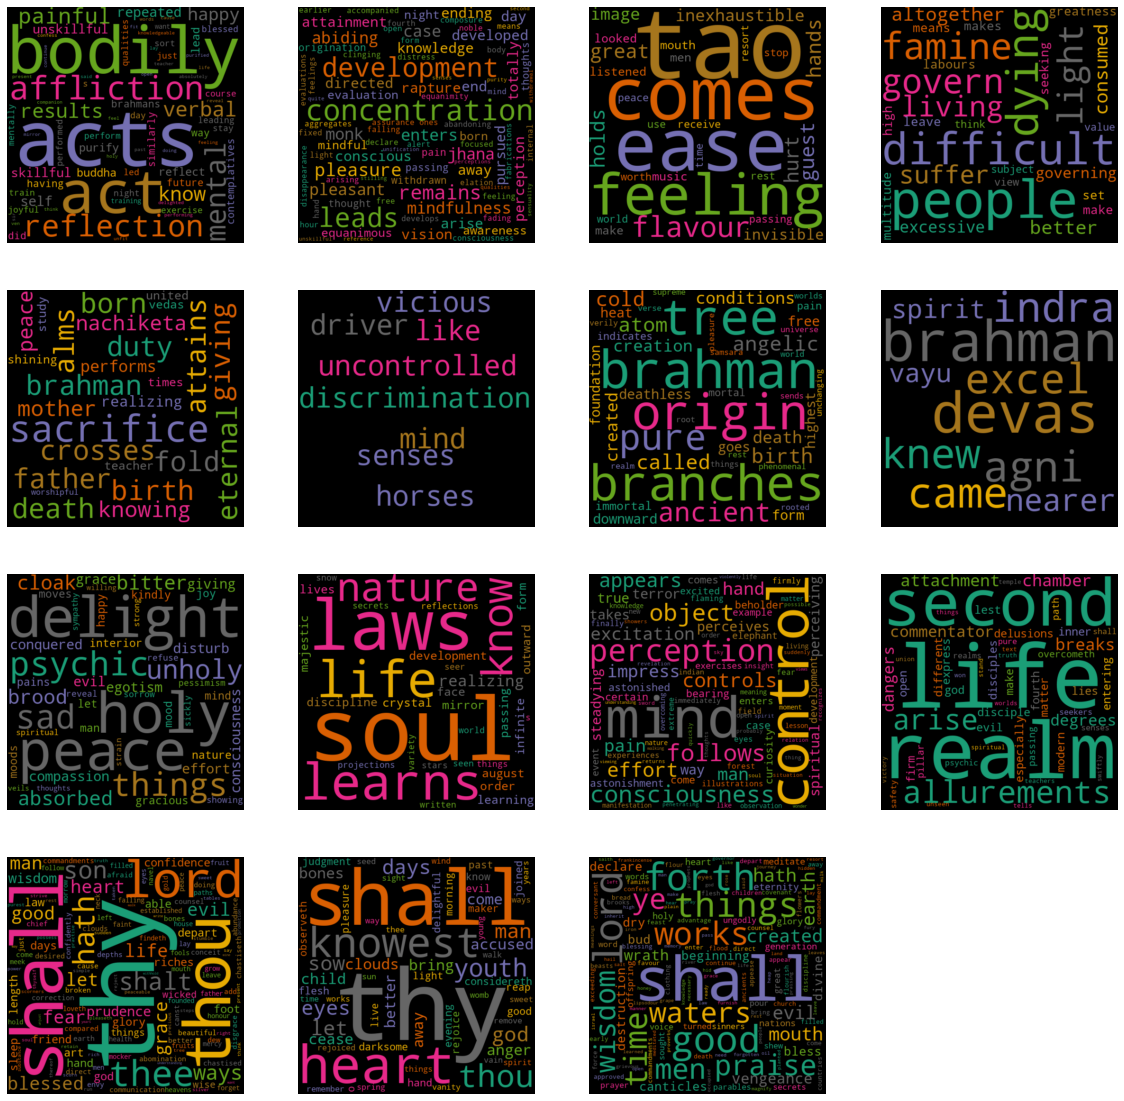

In [89]:
fig = plt.figure(figsize=(20, 20))
i = 1
for idx in range(0, 590,40): 
    fig.add_subplot(4, 4, i)
    plt.imshow(generate_wordcloud(df_word_count.iloc[idx, :], title=f'tekst {idx}'), interpolation='bilinear')
    plt.axis('off')
    i += 1
plt.show()

In [120]:
df_features.groupby('nmf_topics').mean()

,Unique,no_of_words,polarity,subjectivity,FRE,ARI
nmf_topics,,,,,,
Brahman and Worship,24.847222,29.694444,0.112353,0.446805,30.604722,25.666667
Christianity - God,149.479167,225.270833,0.162152,0.575101,70.716458,11.529167
Hinduism - Eternal Beings,38.032258,48.580645,0.114349,0.459869,21.101613,30.620968
Lord's Wisdom,147.972973,216.608108,0.174878,0.588944,73.728108,10.525676
Mind and Intellect,39.224138,49.655172,0.121675,0.486562,18.252759,30.822414
Noble Monk Perception,52.000000,127.372549,0.118620,0.461235,43.792745,18.588235
Spirituality and Consciousness,46.436508,59.571429,0.128824,0.409205,46.394762,17.974603
Tao does great things,48.780000,61.020000,0.149463,0.520402,-38.459700,53.664000


In [121]:
df_features.groupby('lda_topics').mean()

,Unique,no_of_words,polarity,subjectivity,FRE,ARI
lda_topics,,,,,,
Christianity - God,154.819672,229.016393,0.170709,0.588639,73.492705,10.643443
Fear and Love,46.214286,57.214286,0.154920,0.495724,36.037143,24.428571
Feeling and Consciousness,43.208333,85.791667,0.126990,0.526575,-9.389583,40.929167
Knowledge and Mind Perception,39.000000,58.202703,0.118898,0.478869,18.886216,29.601351
Monk - Body and Mind,41.933333,87.366667,0.084108,0.390883,16.028667,30.993333
Property and Knowledge,38.653846,53.897436,0.117257,0.461632,14.098974,31.876923
Spiritual Man Life and Soul,43.082051,55.866667,0.126531,0.437754,30.263333,25.311282
Taoism - Intellect,33.259259,39.814815,0.166735,0.505336,-8.718889,42.231481


# Obserwacje
## Ogólne
1. Najczęstszymi tematami są chrześcijaństwo oraz hinduizm.
2. Wszystkie teksty religijne są nacechowane raczej pozytywnie.
3. Omawiane teskty są napisane dość trudnym językiem.
4. Teksty zostały uznane za subiektywne.

## Szczegółowe
1. Zdecydowanie najdłuższe są teksty chrześcijańskie.
2. Jeśli chodzi o nacechowanie pozytywne to najlepiej wypada chrześcijaństwo i taoism, jednak różnice nie są zbyt duże.
3. Najbardziej obiektywne są teksty o mnichach oraz o duchowości.
4. Taoism ma bardzo skomplikowane teksty(FRE < 0).
5. Najłatwiejsze do zrozumienia są teksty chrześcijańskie.